In [2]:
cd ..

/home/jovyan/Capstone/Github_my_version


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.svm import SVR, SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [199]:
apple_df = pd.read_csv("data/combined_horizontal")
targets = pd.read_csv("data/sandp500/individual_stocks_15yr_buy_or_sell/AAPL_data.csv")

In [200]:
targets = targets.tail(3525)
targets.shape

(3525, 99)

In [201]:
apple_df = apple_df.set_index("Date")

In [202]:
apple_df.shape

(3525, 195)

In [203]:
train = apple_df[:2645]
test = apple_df[2645:]

In [204]:
y_train = train['targets']
y_test = test['targets']

In [286]:
X_train = train.drop('targets', 1)
X_test = test.drop('targets', 1)

In [206]:
train_scaled = StandardScaler()
X_train = train_scaled.fit_transform(X_train)

In [207]:
test_scaled = StandardScaler()
X_test = test_scaled.fit_transform(X_test)

In [208]:
y = apple_df['targets']
apple_df = apple_df.drop('targets', 1)
apple_df.shape

(3525, 194)

In [209]:
amazon = pd.read_csv("data/sandp500/individual_stocks_15yr_TECHNICALS/AMZN_data.csv")
amazon = amazon.set_index('Date')

In [210]:
w_amazon = pd.concat([apple_df, amazon], axis = 1, join='inner')
w_amazon['targets'] = y
w_amazon.shape

(3525, 291)

In [211]:
w_amazon_train = w_amazon[:2645]
w_amazon_test = w_amazon[2645:]

In [212]:
w_amazon_y_train = y_train
w_amazon_y_test = y_test

In [213]:
w_amazon_X_train = w_amazon_train.drop('targets', 1)
w_amazon_X_test = w_amazon_test.drop('targets', 1)

In [214]:
w_amazon_train_scaled = StandardScaler()
w_amazon_X_train = w_amazon_train_scaled.fit_transform(w_amazon_X_train)

In [215]:
w_amazon_test_scaled = StandardScaler()
w_amazon_X_test = w_amazon_test_scaled.fit_transform(w_amazon_X_test)

In [216]:
X_train.shape

(2645, 194)

In [217]:
w_amazon_X_train.shape

(2645, 290)

## KernelPCA with Lasso

In [21]:
kpca_lasso_pipeline = Pipeline([
    ('scaler',StandardScaler()),
    ('kpca', KernelPCA(random_state = 42,
                       n_components = 31)),
    ('model', Lasso(random_state = 42))
     ])

In [22]:
kpca_lasso_params = {
    'model__alpha': np.logspace(-2, 3, 5),
    'kpca__gamma':np.logspace(-3, 2, 7),
    'kpca__kernel':['sigmoid', 'rbf', 'poly', 'linear', 'cosine'], #'precomputed'],
    #'kpca__n_components':np.arange(1, 100, 8),
    'kpca__degree':np.arange(1, 6, 1)
    
}

In [23]:
kpca_lasso_gs = GridSearchCV(kpca_lasso_pipeline, 
                      kpca_lasso_params,
                      cv=3, verbose = 1)

In [24]:
kpca_lasso_gs.fit(X_train, y_train)

Fitting 3 folds for each of 875 candidates, totalling 2625 fits


[Parallel(n_jobs=1)]: Done 2625 out of 2625 | elapsed: 123.1min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kpca', KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, kernel='linear',
     kernel_params=None, max_iter=None, n_components=31, n_jobs=1,
     rando...ive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'model__alpha': array([  1.00000e-02,   1.77828e-01,   3.16228e+00,   5.62341e+01,
         1.00000e+03]), 'kpca__gamma': array([  1.00000e-03,   6.81292e-03,   4.64159e-02,   3.16228e-01,
         2.15443e+00,   1.46780e+01,   1.00000e+02]), 'kpca__kernel': ['sigmoid', 'rbf', 'poly', 'linear', 'cosine'], 'kpca__degree': array([1, 2, 3, 4, 5])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [276]:
kpca_lasso_gs.best_estimator_.fit(X_train, y_train)
kpca_lasso_gs.best_estimator_.score(X_train, y_train)

0.57477043877323575

In [277]:
kpca_lasso_gs.best_params_

{'kpca__degree': 1,
 'kpca__gamma': 100.0,
 'kpca__kernel': 'poly',
 'model__alpha': 0.17782794100389229}

In [278]:
pred = kpca_lasso_gs.best_estimator_.predict(X_test)
actual = y_test

In [279]:
mean_absolute_error(actual, pred)

0.16001618326349581

In [280]:
mean_squared_error(actual, pred)

0.036982585518048304

In [281]:
kpca_lasso_gs.best_estimator_.score(X_test, y_test)

0.55317739119009857

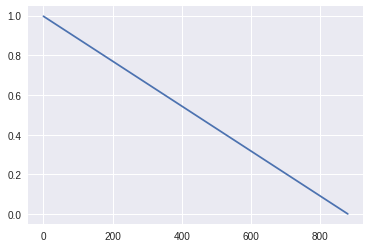

In [282]:
plt.plot(actual.values)

In [50]:
apple = pd.read_csv('data/sandp500/individual_stocks_15yr/AAPL_data.csv')

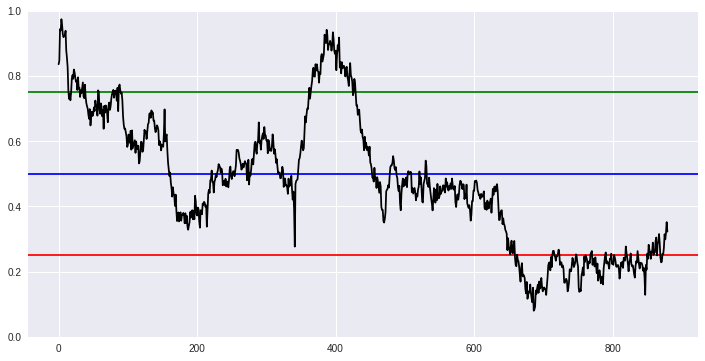

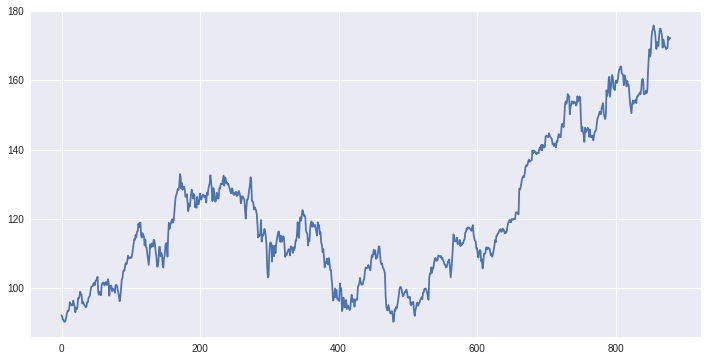

In [284]:
plt.figure(figsize=(12,6))
plt.ylim(0, 1)
plt.axhline(0.75, color = 'g')
plt.axhline(0.25, color = 'r')
plt.axhline(0.5, color = 'blue')
plt.plot(pred, color = 'black')

closes = apple['Close']
test_closes = closes.tail(880)
xx = np.arange(len(test_closes))
plt.figure(figsize=(12,6))
plt.plot(xx, test_closes)

With 0.8 as buy threshold and 0.2 as sell threshold:
- Buy on June 18, 2014 (Price of $92.18)

- Sell on February 8, 2017 (Price of $132.04)

In [128]:
kpca = KernelPCA(random_state = 42,
                       n_components = 31,
                      degree = 1,
                      gamma = 100,
                      kernel = 'poly')
projected = kpca.fit_transform(X_train)
print(X_train.shape)
print(projected.shape)

(2645, 194)
(2645, 31)


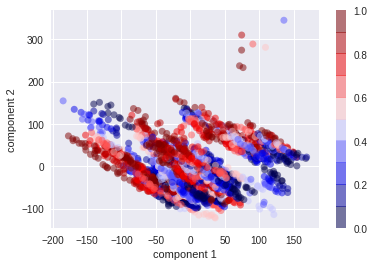

In [129]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=w_amazon_y_train, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

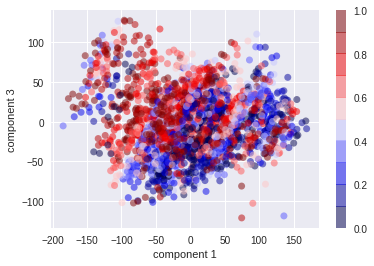

In [130]:
plt.scatter(projected[:, 0], projected[:, 2],
            c=w_amazon_y_train, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 1')
plt.ylabel('component 3')
plt.colorbar();

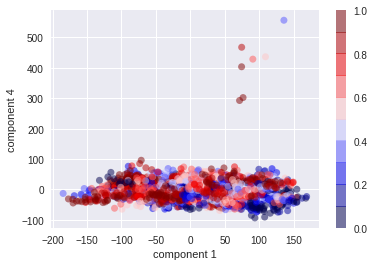

In [131]:
plt.scatter(projected[:, 0], projected[:, 3],
            c=w_amazon_y_train, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 1')
plt.ylabel('component 4')
plt.colorbar();

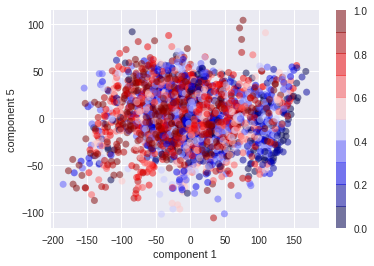

In [132]:
plt.scatter(projected[:, 0], projected[:, 4],
            c=w_amazon_y_train, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 1')
plt.ylabel('component 5')
plt.colorbar();

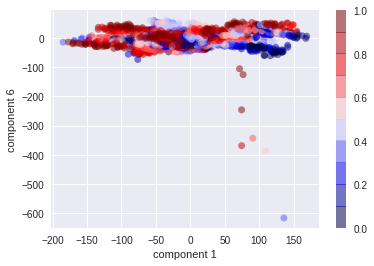

In [133]:
plt.scatter(projected[:, 0], projected[:, 5],
            c=w_amazon_y_train, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('seismic', 10))
plt.xlabel('component 1')
plt.ylabel('component 6')
plt.colorbar();

## Predicting Apple Target Using Technicals from Apple, Microsoft and Amazon

In [287]:
kpca_test_lasso_pipeline = Pipeline([
    ('scaler',StandardScaler()),
    ('kpca', KernelPCA(random_state = 42,
                       n_components = 31,
                      degree = 1,
                      gamma = 100,
                      kernel = 'poly')),
    ('model', Lasso(random_state = 42, alpha = 0.17782794100389229))
     ])

In [288]:
kpca_test_lasso_pipeline.fit(w_amazon_X_train, w_amazon_y_train)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kpca', KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=1, eigen_solver='auto',
     fit_inverse_transform=False, gamma=100, kernel='poly',
     kernel_params=None, max_iter=None, n_components=31, n_jobs=1,
     random_s...ive=False, precompute=False,
   random_state=42, selection='cyclic', tol=0.0001, warm_start=False))])

In [289]:
kpca_test_lasso_pipeline.score(w_amazon_X_train, w_amazon_y_train)

0.53304038293701894

In [290]:
kpca_test_lasso_pipeline.score(w_amazon_X_test, w_amazon_y_test)

0.5299683388553782

In [291]:
pred = kpca_test_lasso_pipeline.predict(w_amazon_X_test)
actual = w_amazon_y_test

In [292]:
mean_absolute_error(actual, pred)

0.16804037343420147

In [293]:
mean_squared_error(actual, pred)

0.038903550898577721

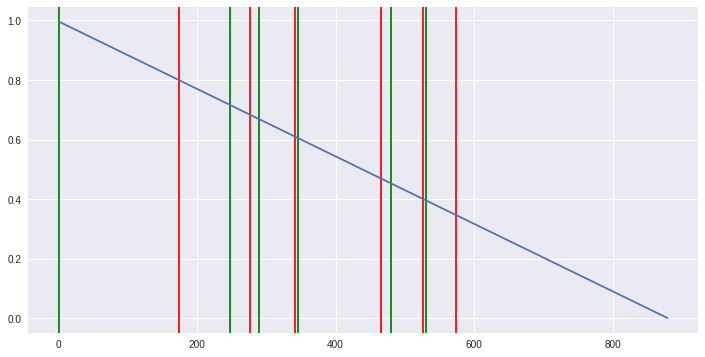

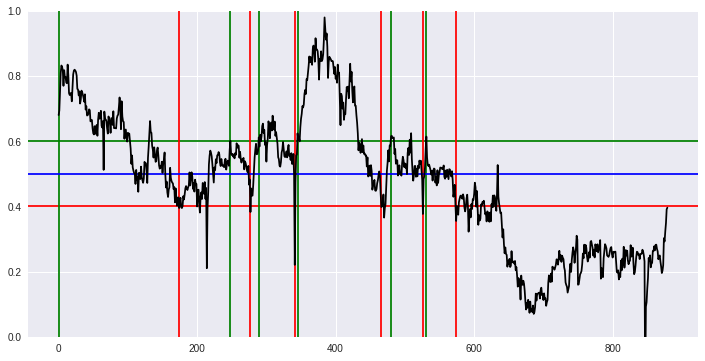

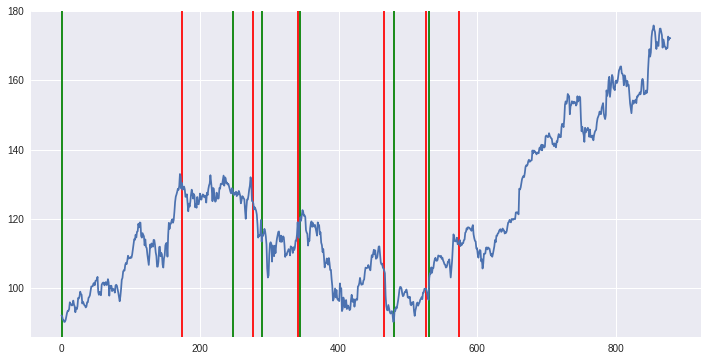

In [295]:
plt.figure(figsize=(12,6))
plt.axvline(0, color = 'g')
plt.axvline(174, color = 'r')
plt.axvline(248, color = 'g')
plt.axvline(277, color = 'r')
plt.axvline(289, color = 'g')
plt.axvline(341, color = 'r')
plt.axvline(345, color = 'g')
plt.axvline(466, color = 'r')
plt.axvline(480, color = 'g')
plt.axvline(526, color = 'r')
plt.axvline(531, color = 'g')
plt.axvline(574, color = 'r')
plt.plot(actual.values)


plt.figure(figsize=(12,6))
plt.ylim(0, 1)
plt.axhline(0.6, color = 'g')
plt.axhline(0.4, color = 'r')
plt.axvline(0, color = 'g')
plt.axvline(174, color = 'r')
plt.axvline(248, color = 'g')
plt.axvline(277, color = 'r')
plt.axvline(289, color = 'g')
plt.axvline(341, color = 'r')
plt.axvline(345, color = 'g')
plt.axvline(466, color = 'r')
plt.axvline(480, color = 'g')
plt.axvline(526, color = 'r')
plt.axvline(531, color = 'g')
plt.axvline(574, color = 'r')
plt.axhline(0.5, color = 'blue')
plt.plot(pred, color = 'black')

closes = apple['Close']
test_closes = closes.tail(880)
xx = np.arange(len(test_closes))
plt.figure(figsize=(12,6))
plt.axvline(0, color = 'g')
plt.axvline(174, color = 'r')
plt.axvline(248, color = 'g')
plt.axvline(277, color = 'r')
plt.axvline(289, color = 'g')
plt.axvline(341, color = 'r')
plt.axvline(345, color = 'g')
plt.axvline(466, color = 'r')
plt.axvline(480, color = 'g')
plt.axvline(526, color = 'r')
plt.axvline(531, color = 'g')
plt.axvline(574, color = 'r')
plt.plot(xx, test_closes)

In [328]:
test_closes = test_closes.reset_index(drop=True)
test_closes[0]

92.180000000000007

## Predicting Amazon Target using Technicals from Apple, Microsoft and Amazon

In [329]:
amazon_target = pd.read_csv('data/sandp500/individual_stocks_15yr_buy_or_sell/AMZN_data.csv')

In [330]:
amazon_target = amazon_target.set_index('Date', 1)
amazon_target = amazon_target.drop('Unnamed: 0', 1)
amazon_target.shape

(3526, 97)

In [331]:
targets = amazon_target['targets']

In [332]:
amazon_df = w_amazon.drop('targets', 1)
amazon_df['targets'] = targets

In [333]:
amazon_train = amazon_df[:2645]
amazon_test = amazon_df[2645:]

In [334]:
y_train = amazon_train['targets']
y_test = amazon_test['targets']

In [335]:
X_train = amazon_train.drop('targets', 1)
X_test = amazon_test.drop('targets', 1)

In [336]:
train_sc = StandardScaler()
X_train = train_sc.fit_transform(X_train)

In [337]:
test_sc = StandardScaler()
X_test = test_sc.fit_transform(X_test)

In [338]:
kpca_test_lasso_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kpca', KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=1, eigen_solver='auto',
     fit_inverse_transform=False, gamma=100, kernel='poly',
     kernel_params=None, max_iter=None, n_components=31, n_jobs=1,
     random_s...ive=False, precompute=False,
   random_state=42, selection='cyclic', tol=0.0001, warm_start=False))])

In [339]:
kpca_test_lasso_pipeline.score(X_train, y_train)

0.53791730237378677

In [340]:
kpca_test_lasso_pipeline.score(X_test, y_test)

0.19301355416976207

In [341]:
pred = kpca_test_lasso_pipeline.predict(X_test)
actual = y_test

In [342]:
mean_absolute_error(actual, pred)

0.21698651819891121

In [343]:
mean_squared_error(actual, pred)

0.06731436436889815

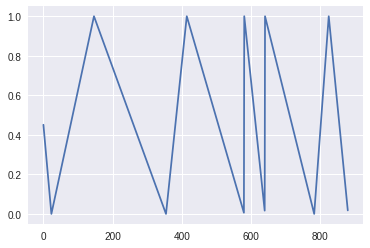

In [344]:
plt.plot(actual.values)

In [345]:
amazon = pd.read_csv('data/sandp500/individual_stocks_15yr/AMZN_data.csv')

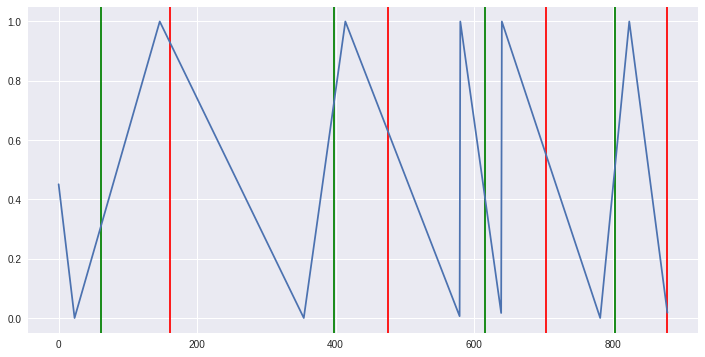

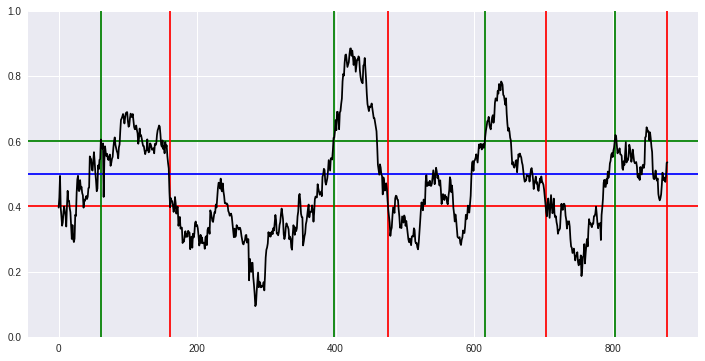

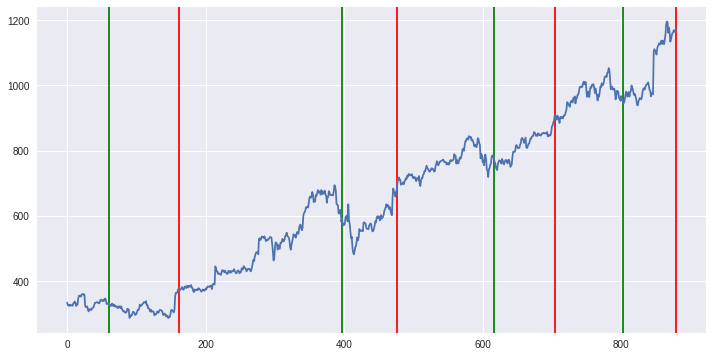

In [346]:
plt.figure(figsize=(12,6))
plt.axvline(61, color = 'g')
plt.axvline(161, color = 'r')
plt.axvline(397, color = 'g')
plt.axvline(476, color = 'r')
plt.axvline(616, color = 'g')
plt.axvline(704, color = 'r')
plt.axvline(803, color = 'g')
plt.axvline(879, color = 'r')
plt.plot(actual.values)

plt.figure(figsize=(12,6))
plt.ylim(0, 1)
plt.axhline(0.6, color = 'g')
plt.axhline(0.4, color = 'r')
plt.axvline(61, color = 'g')
plt.axvline(161, color = 'r')
plt.axvline(397, color = 'g')
plt.axvline(476, color = 'r')
plt.axvline(616, color = 'g')
plt.axvline(704, color = 'r')
plt.axvline(803, color = 'g')
plt.axvline(879, color = 'r')
plt.axhline(0.5, color = 'blue')
plt.plot(pred, color = 'black')

closes = amazon['Close']
test_closes = closes.tail(880)
xx = np.arange(len(test_closes))
plt.figure(figsize=(12,6))
plt.axvline(61, color = 'g')
plt.axvline(161, color = 'r')
plt.axvline(397, color = 'g')
plt.axvline(476, color = 'r')
plt.axvline(616, color = 'g')
plt.axvline(704, color = 'r')
plt.axvline(803, color = 'g')
plt.axvline(879, color = 'r')
plt.plot(xx, test_closes)

In [360]:
test_closes = test_closes.reset_index(drop=True)
test_closes[0]

334.38